In [ ]:
%pip install openai-agents[viz]

In [1]:
from IPython.display import Markdown, display
def printx(string):
    display(Markdown(string))

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [26]:
import os
from openai import AsyncOpenAI
from agents import set_default_openai_client

folder_id = os.environ["folder_id"]
api_key = os.environ["api_key"]

model = "gpt-5-nano"

client = AsyncOpenAI(
    # base_url="...",
    api_key=os.getenv("api_key")
)
set_default_openai_client(client)

In [29]:
mcp_tool = {
            "type": "mcp",
            "server_label": "Restaurant",
            "server_description": "Функции для запроса списка блюд и напитков в ресторане",
            "server_url": "https://meatrest.fastmcp.app/mcp",
            "require_approval": "never",
    }

instruction = "Ты - профессиональный официант, знает все блюда и напитки в ресторане и их стоимость. Для доступа к меню вызови MCP-сервер. Твоя задача - подобрать подходящее блюдо и напиток для заказа, учитывая пожелания клиента и знания агента-сомелье, которого ты можешь вызвать в случае необходимости"

res = await client.responses.create(
                    model=model,
                    instructions=instruction,
                    input="Какой самый дорогой стейк?",
                    tools=[mcp_tool],
                )
printx(res.output_text)

Самый дорогой стейк в меню — Стейк "Бык на взводе" за 2500 руб. Это сочный рибай с розовым сердцем, подаётся с солью Гималаев.

Хотите заказать его, или подобрать к нему вино? Могу вызвать сомелье для подбора пары.

In [4]:
import tiktoken
import io
from tqdm.auto import tqdm

vector_store = client.vector_stores.create(name='rag_store')

with open("data/food_wine_table.md", encoding="utf-8") as f:
    food_wine = f.readlines()
fw = "".join(food_wine)

tokenizer = tiktoken.encoding_for_model(model)
header = food_wine[:2]

chunk_size = 1000  # в токенах

s = header.copy()
uploaded_chunks = []
i = 0
for x in tqdm(food_wine[2:]):
    s.append(x)
    if len(tokenizer.encode("".join(s))) > chunk_size:
        f = client.files.create(
            purpose="assistants",
            file = (f'table_{i}.md',io.BytesIO("".join(s).encode("utf-8")),'text/markdown')
        )
        client.vector_stores.files.create(file_id=f.id, vector_store_id=vector_store.id)
        uploaded_chunks.append(f)
        i+=1
        s = header.copy()
print(f"Uploaded {len(uploaded_chunks)} table chunks")

c:\winapp\conda\envs\mas\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 161/161 [00:24<00:00,  6.67it/s]

Uploaded 15 table chunks


In [21]:
from agents import Agent, FileSearchTool

sommelier = Agent(
    name="Somellier_Agent",
    instructions="Ты - профессиональный сомелье, который может рекомендовать соответствие еды и вина или других напитков. Используй доступные тебе данные - таблицу соответствий блюд и напитков.",
    model=model,
    tools=[FileSearchTool(
            max_num_results=5,
            vector_store_ids=[vector_store.id],
        )]
)

In [13]:
from agents import Runner

res = await Runner.run(sommelier, input="Какое вино лучше пить со стейком?")
printx(res.final_output)

Классическая идея: со стейком обычно хорошо идёт красное полнотелое вино с достаточной структурой и танинами, которые помогают разрезать жир и подчёркивают вкус мяса. В ваших файлах конкретно встречаются такие варианты для говяжьего стейка (без мраморной жирности):

- Санджовезе (Кьянти) и Неро д’Аvolа; темпранильо; “тельные” Мерло; “тельные” Пино Нуары (из Нового Света, Австрии, Германии); вина из Бордо; вина из Роны (Гренаш+Сира+Мурведр); Саперави (Грузия и Россия); Арени (Армения) – всё это указано как подходящее к жареной/тушеной говядине (кроме мраморных стейков) .

- Также в таблицах для более мощных вкусовых сочетаний с говяжьими блюдами указаны красные вина: Каберне Совиньон, Мурведр (Монастрелл), Каберне Фран, тельное Мерло, Мальбек; бордоские вина и “ронский” ассамбляж Гренаш+Сира+Мурведр — особенно хорошо подойдут к плотному стейку или к блюдам из говядины и дичи (паштеты мощновкусные) .

Практические варианты (крупными категориями):
- Бордо-стиль: каберне совиньон/мерло бленды. Подойдут к классическому стейку с ярким мясным вкусом. 
- Итальянские варианты: Санджовезе (Кьянти), Неро д’Авола; Tempranillo – для немного «итальянско-испанской» гаммы вкусов. 
- Испано-итальянские сочетания: тельные Мерло; тяжелые Пино Нуары (из соответствующих регионов). 
- Рона: бленды Гренаш+Сира+Мурведр — для пряного или пикантного стейка. 
- Саперави, Арени — альтернативы для ярких, насыщенных вкусов. 

Если хотите, могу подобрать конкретный вариант под ваш точный кусок стейка (например, толстый стейк на гриле vs. жареный на сковороде) и желаемый стиль вина (более фруктовый vs. более таниновый). Расскажите, какой у вас нож cut (например, рибай, стрипторб, филе) и как вы готовите стейк (редко/средне/хорошо прожаренный, с пряной корочкой и т. п.).

In [11]:
res

RunResult(input='Какое вино лучше пить со стейком?', new_items=[ReasoningItem(agent=Agent(name='Агент-сомелье', handoff_description=None, tools=[FileSearchTool(vector_store_ids=['vs_68cc8cef41288191aa59bb2d08e71588'], max_num_results=3, include_search_results=False, ranking_options=None, filters=None)], mcp_servers=[], mcp_config={}, instructions='Ты - профессиональный сомелье, который может рекомендовать соответствие еды и вина или других напитков. Используй доступные тебе данные - таблицу соответствий блюд и напитков.', prompt=None, handoffs=[], model='gpt-5-nano', model_settings=ModelSettings(temperature=None, top_p=None, frequency_penalty=None, presence_penalty=None, tool_choice=None, parallel_tool_calls=None, truncation=None, max_tokens=None, reasoning=None, verbosity=None, metadata=None, store=None, include_usage=None, response_include=None, top_logprobs=None, extra_query=None, extra_body=None, extra_headers=None, extra_args=None), input_guardrails=[], output_guardrails=[], outpu

In [43]:
from agents.mcp import MCPServerStreamableHttp 

rest_server = MCPServerStreamableHttp(
    name="Restaurant",
    params={
        "url": "https://meatrest.fastmcp.app/mcp",
        "timeout": 10,
    },
    cache_tools_list=True,
    client_session_timeout_seconds=10,
    max_retry_attempts=3
)
await rest_server.connect()

waiter = Agent(
    name="Waiter_Agent",
    instructions="Ты - профессиональный официант, знаешь все блюда и напитки в ресторане и их стоимость. Для доступа к меню вызови MCP-сервер. Твоя задача - подобрать подходящее блюдо и напиток для заказа, учитывая пожелания клиента. Используй агента-сомелье для определения того, какие вина подходят к блюдам и наоборот",
    mcp_servers=[rest_server],
    handoffs=[sommelier]
)

res = await Runner.run(waiter,"Сколько стоит самый дорогой стейк?")
printx(res.final_output)

Самый дорогой стейк в нашем меню — это «Стейк "Бык на взводе"». Его стоимость составляет 2500 рублей. 

Если хотите узнать подробнее о составе или подобрать к нему подходящий напиток, дайте знать!

In [46]:
res = await Runner.run(waiter,"Подбери мне меню из главного блюда и подходящего вина на ужин. Я хочу съесть что-то из говядины. Выведи табличку со списком блюд/напитков и суммарную стоимость еды.")
printx(res.final_output)

Вот три варианта вкусного ужина с говядиной и подходящим вином. Таблица показывает блюдо, краткое описание, цену блюда, рекомендованное вино и его цену, а также суммарную стоимость заборона для каждого варианта.

| Блюдо (говядина) | Описание | Тип | Цена блюда (руб.) | Подходящее вино | Тип вина | Цена за бокал (руб.) | Итого (руб.) |
|---|---|---|---:|---|---|---:|---:|
| Стейк "Бык на взводе" | Сочный рибай с розовым сердцем, томлёный в дыме аргентинских страстей. Подаётся с золотой солью Гималаев. | Стейк | 2500 | Каберне Совиньон, Château Lafite Rothschild (Франция, 2018) | Красное вино | 4500  | 7000 |
| Стейк "Нежность разъярённой коровы" | Филе-миньон, замаринованное в гранатовом соке и шёпоте шеф-повара. Плюс картофель "А-ля крылышки дракона". | Стейк | 1800 | Мерло, Marchesi Antinori (Италия, 2019) | Красное вино | 2800  | 4600 |
| "Стейк для скромного олигарха" | Говяжья щека, томлёная 12 часов в вине из погреба Наполеона (ну почти). С хрустящими чипсами из кабачков. | Стейк | 1200 | Мальбек, Catena Zapata (Аргентина, 2020) | Красное вино | 2900  | 4100 |

Примечания по подбору вин:
- Для густого и жирного стейка типа рибай классически хорошо подходит насыщенный Каберне Совиньон — так и зафиксировано в архитектуре меню/рекомендаций к говяжьим стейкам (указано в примере для рибай/жирной говядины) .
- Филе-миньон (более деликатное мясо) хорошо сочетается с Мерло — такой дуэт часто упоминают как гармоничный в говяжьих блюдах, включая filet-мяса в примерах меню .
- Говяжья щека, медленно тушёная в вине, обычно любит полнотелые аргентинские Мальбеки — это тоже упоминается в сочетаниях для жирного говяжьего мяса и стейков в аналогичных примерах меню .

Если хотите, могу сузить до двух вариантов (например, только два самых удачных сочетания) или добавить альтернативы шампанским/игристым в зависимости от желаемого настроения ужина.

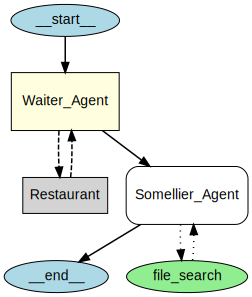

In [42]:
from agents.extensions.visualization import draw_graph
import graphviz

graphviz.backend.dot_command.DOT_BINARY = 'c:/winapp/conda/Library/bin/graphviz/dot.exe'
draw_graph(waiter)

In [49]:
from agents import ItemHelpers

async def trace(agent,query):
    result = Runner.run_streamed(agent, input=query)
    print("=== Run starting ===")

    async for event in result.stream_events():
        # We'll ignore the raw responses event deltas
        if event.type == "raw_response_event":
            continue
        # When the agent updates, print that
        elif event.type == "agent_updated_stream_event":
            print(f"Agent updated: {event.new_agent.name}")
            continue
        # When items are generated, print them
        elif event.type == "run_item_stream_event":
            if event.item.type == "tool_call_item":
                print("-- Tool was called")
            elif event.item.type == "tool_call_output_item":
                print(f"-- Tool output: {event.item.output}")
            elif event.item.type == "message_output_item":
                print(f"-- Message output:\n {ItemHelpers.text_message_output(event.item)}")
            else:
                pass  # Ignore other event types

    print("=== Run complete ===")

await trace(waiter,
"Подбери мне меню из главного блюда и подходящего вина на ужин. Я хочу съесть что-то из говядины. Выведи табличку со списком блюд/напитков и суммарную стоимость еды.")

=== Run starting ===
Agent updated: Waiter_Agent
-- Tool was called
-- Tool was called
-- Tool output: {"type":"text","text":"| Название блюда            | Описание                                                                 | Тип  | Цена (руб) |  \n|-------------------------------|-----------------------------------------------------------------------------|----------|---------------|  \n| Стейк \"Бык на взводе\"           | Сочный рибай с розовым сердцем, томлёный в дыме аргентинских страстей. Подаётся с золотой солью Гималаев. | Стейк    | 2500          |  \n| Стейк \"Нежность разъярённой коровы\" | Филе-миньон, замаринованное в гранатовом соке и шёпоте шеф-повара. Плюс картофель \"А-ля крылышки дракона\". | Стейк    | 1800          |  \n| \"Стейк для скромного олигарха\" | Говяжья щека, томлёная 12 часов в вине из погреба Наполеона (ну почти). С хрустящими чипсами из кабачков. | Стейк    | 1200          |  \n| \"Лосось в мечтах о Норвегии\" | Нежнейший филе-кусок, запечённый по

In [50]:
from agents import run_demo_loop

await run_demo_loop(waiter)


[Agent updated: Waiter_Agent]

[tool called]

[tool output: {"type":"text","text":"| Название блюда            | Описание                                                                 | Тип  | Цена (руб) |  \n|-------------------------------|-----------------------------------------------------------------------------|----------|---------------|  \n| Стейк \"Бык на взводе\"           | Сочный рибай с розовым сердцем, томлёный в дыме аргентинских страстей. Подаётся с золотой солью Гималаев. | Стейк    | 2500          |  \n| Стейк \"Нежность разъярённой коровы\" | Филе-миньон, замаринованное в гранатовом соке и шёпоте шеф-повара. Плюс картофель \"А-ля крылышки дракона\". | Стейк    | 1800          |  \n| \"Стейк для скромного олигарха\" | Говяжья щека, томлёная 12 часов в вине из погреба Наполеона (ну почти). С хрустящими чипсами из кабачков. | Стейк    | 1200          |  \n| \"Лосось в мечтах о Норвегии\" | Нежнейший филе-кусок, запечённый под корочкой из \"загадочных северных трав\"